### Setup

In [1]:
from openai import OpenAI
from tqdm import tqdm
import os
import math
from tvalmetrics import RagScoresCalculator
from concurrent.futures import ThreadPoolExecutor

client = OpenAI()

In [2]:
RUN_COMBINE_ESSAYS = True

def get_sorted_essays():
    # Sort the files so that they are uploaded in order
    combined_essays = os.listdir('combined_essays')
    combined_essays.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))
    print("\n".join(combined_essays))
    return combined_essays

# Iterate through paul_graham_essays folder and upload each file to the assistant
# Apparently you can't upload more than 20 items to openai's rag so let's just combine them and upload those
def combine_essays(group_num):
    if not RUN_COMBINE_ESSAYS:
        return
    essays = os.listdir('paul_graham_essays')
    group_size = math.ceil(len(essays) / group_num)
    print(f"Grouping {len(essays)} files into groups of {group_size} files for a total of {group_num} groups")


    # Create directory for combined essays
    if not os.path.exists('combined_essays'):
        os.makedirs('combined_essays')
    else:
        # delete all files in combined_essays
        for filename in os.listdir('combined_essays'):
            os.remove(f'combined_essays/{filename}')

    group_counter = 0
    file_counter = 1
    curr_file_text = ""
    for filename in tqdm(essays):
        with open('paul_graham_essays/' + filename, 'r') as file:
            curr_file_text += file.read().strip() + "\n\n\n\n"
            group_counter += 1
            if group_counter == group_size:
                # Write to file
                with open(f'combined_essays/paul_graham_{file_counter}.txt', 'w') as combined_file:
                    combined_file.write(curr_file_text)
                    file_counter += 1
                curr_file_text = ""
                group_counter = 0
    
    if curr_file_text.strip():
        with open(f'combined_essays/paul_graham_{file_counter}.txt', 'w') as combined_file:
            combined_file.write(curr_file_text)
    return get_sorted_essays()

In [3]:
import time


def get_response(prompt, assistant):
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_tries = 180
    try:
        while True:
            if max_tries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            response_message = messages.data[0].content[0].text.value
            if response_message != prompt and response_message.strip():
                annotations = messages.data[0].content[0].text.annotations
                quotes = [x.file_citation.quote for x in annotations if x.file_citation]
                client.beta.threads.delete(thread.id)
                return (response_message, quotes)
            time.sleep(1)
            max_tries -= 1
    except Exception as e:
        client.beta.threads.delete(thread.id)
        raise e

In [4]:
# Load questions from qa_pairs.json
import json
qa_pairs = []
with open('qa_pairs.json', 'r') as qa_file:
    qa_pairs = json.load(qa_file)

question_list = [qa_pair['question'] for qa_pair in qa_pairs]
print("Questions:\n" + "\n".join(question_list[:4]))

print()

answer_list = [qa_pair['answer'] for qa_pair in qa_pairs]
print("Answers:\n" + "\n".join(question_list[:4]))

Questions:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?

Answers:
What key components are necessary to create a technology hub according to Paul Graham?
What is the influence of geography on where great cities historically developed, and how has that changed in modern times?
How are people classified according to their degree and aggressiveness of conformism?
What is the main danger of restricting the discussion of certain ideas?


In [5]:
score_calculator = RagScoresCalculator(
    model="gpt-4-1106-preview",
    answer_similarity_score=True,
)

In [6]:
import tiktoken
def count_tokens(text):
    enc = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(enc.encode(text))
    return num_tokens

#### Cleanup

In [7]:
# Do not run the following unless you want to delete all files and assistants

# def cleanup_files():
#     curr_files = list(client.files.list())
#     for file in tqdm(curr_files):
#         client.files.delete(file.id)

# def cleanup_assistants():
#     curr_assistants = list(client.beta.assistants.list())
#     for curr_assistant in tqdm(curr_assistants):
#         client.beta.assistants.delete(curr_assistant.id)

# def cleanup_all():
#     print("Cleaning up files")
#     cleanup_files()
#     print("Cleaning up assistants")
#     cleanup_assistants()

# cleanup_all()


Cleaning up files


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Cleaning up assistants


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


### OpenAI's RAG

#### Setup

In [8]:
def upload_essays(combined_essays):
    # Go through all the combined files and upload them to the assistant
    files = []
    print("Uploading files")
    for filename in tqdm(combined_essays):
        with open('combined_essays/' + filename, 'rb') as essay_file:
            file = client.files.create(
                file=essay_file,
                purpose='assistants'
            )
            files.append(file)
    return files

In [9]:
def create_assistant(files):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test {len(files)} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-1106-preview",
        tools=[{"type": "retrieval"}],
        file_ids=[file.id for file in files]
    )

In [10]:
def setup_assistant(file_count):
    combined_essays = combine_essays(file_count)
    files = upload_essays(combined_essays)
    return create_assistant(files)


In [11]:
# Helper function if you want to view the tokens for each file
def show_file_token_count(essays):
    # Go through all files in combined_essays and then calculate the tokens for each file
    total_tokens = 0
    count = 0
    end_of_selected_files = False
    for filename in essays:
        with open('combined_essays/' + filename, 'r') as file:
            file_tokens = count_tokens(file.read())
            count += 1
            total_tokens += file_tokens
            if filename not in [file.filename for file in files] and not end_of_selected_files:
                print("--- END OF SELECTED FILES ---")
                end_of_selected_files = True
            print(f"File {count}: {filename} has {file_tokens} tokens. Total tokens: {total_tokens}")

#### Testing

In [12]:
assistant = setup_assistant(5)

Grouping 212 files into groups of 43 files for a total of 5 groups


100%|██████████| 212/212 [00:00<00:00, 5782.43it/s]


paul_graham_1.txt
paul_graham_2.txt
paul_graham_3.txt
paul_graham_4.txt
paul_graham_5.txt
Uploading files


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


In [13]:
prompt = "What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?"
openai_response = get_response(prompt, assistant)
print(openai_response)

("I'm sorry, but I wasn't able to find the specific monthly financial goal for Airbnb to achieve ramen profitability during their time at Y Combinator in the excerpts available from Paul Graham's essays. If there is a specific essay or part of an essay where this information might be found, please let me know, or if you have any other questions about Paul Graham's essays, feel free to ask!", [])


In [14]:
openai_responses, openai_context = [], []

In [23]:

# Go through all questions and get responses from openai assistant
for question in tqdm(question_list[len(openai_responses):]):
    # If there is an exception, try again until we reach 3 tries at max
    max_tries = 3
    while True:
        try:
            openai_response = get_response(question, assistant)
            openai_responses.append(openai_response[0])
            openai_context.append(openai_response[1])
            break
        except Exception as e:
            print(e)
            max_tries -= 1
            if max_tries == 0:
                raise e
            continue

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
openai_batch_scores = score_calculator.score_batch(
    question_list=question_list [:len(openai_responses)],
    reference_answer_list=answer_list[:len(openai_responses)],
    llm_answer_list=openai_responses,
)

In [19]:
def run_full_test(file_count):
    assistant = setup_assistant(file_count)
    openai_responses, openai_context = [], []

    def get_openai_response(question):
        max_tries = 10
        while True:
            try:
                response, context = get_response(question, assistant)
                return response, context
            except Exception as e:
                print(e)
                max_tries -= 1
                if max_tries == 0:
                    raise e
                continue
    
    # Using ThreadPoolExecutor to process questions in parallel
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Map the process_question function to each question in the list
        results = list(tqdm(executor.map(get_openai_response, question_list), total=len(question_list)))
    
    openai_responses, openai_context = zip(*results)

    return score_calculator.score_batch(
        question_list=question_list,
        reference_answer_list=answer_list,
        llm_answer_list=openai_responses,
    )


In [20]:
# If we are doing a single document, the reliability is increased enough that we can multithread
# openai_batch_scores = run_full_test(1)

Grouping 212 files into groups of 212 files for a total of 1 groups


100%|██████████| 212/212 [00:00<00:00, 1492.76it/s]


paul_graham_1.txt
Uploading files


 38%|███▊      | 21/55 [00:43<01:13,  2.15s/it]

Error code: 404 - {'error': {'message': "No thread found with id 'thread_1Fy2TaSnMls6MGgFtTHsgoDp'.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 55/55 [04:05<00:00,  4.46s/it]


In [24]:
openai_scores_df = openai_batch_scores.to_dataframe()
# Remove overall_score column since we are only using one stat
openai_scores_df = openai_scores_df.drop(columns=['overall_score'])
openai_scores_df.describe()

,answer_similarity_score
count,55.000000
mean,4.163636
std,1.182647
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


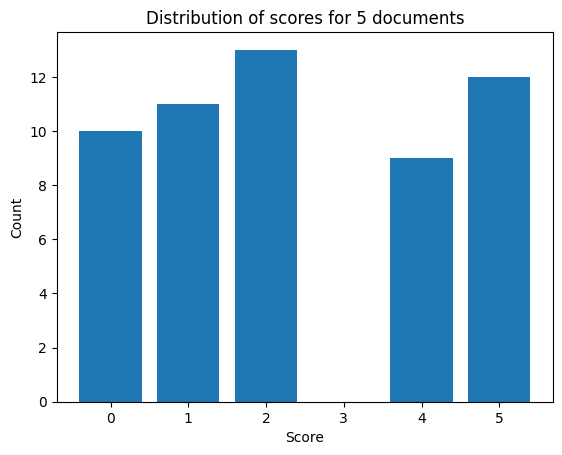

In [35]:
import matplotlib.pyplot as plt
category_counts = openai_scores_df['answer_similarity_score'].value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for 5 documents')
plt.xlabel('Score')
plt.ylabel('Count')

plt.show()